<a href="https://colab.research.google.com/github/Ggenoni/ML_project/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the dataset

In [1]:
import torch
from torchvision import datasets, transforms

# Define transformations for the data
# Note: Modify these transformations based on your model's requirements
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
data_dir = '/data'  # specify your path here
train_dataset = datasets.Flowers102(data_dir, split='train', download=True, transform=transform)
test_dataset = datasets.Flowers102(data_dir, split='test', download=True, transform=transform)

# You can also load a validation set if needed
val_dataset = datasets.Flowers102(data_dir, split='val', download=True, transform=transform)


100%|██████████| 344862509/344862509 [00:16<00:00, 21266040.99it/s]


Extracting path/to/data/flowers-102/102flowers.tgz to path/to/data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1184218.56it/s]


100%|██████████| 14989/14989 [00:00<00:00, 14678595.06it/s]


Create DataLoader

In [2]:
from torch.utils.data import DataLoader

batch_size = 32  # Adjust batch size according to your system's capability

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Explore the data

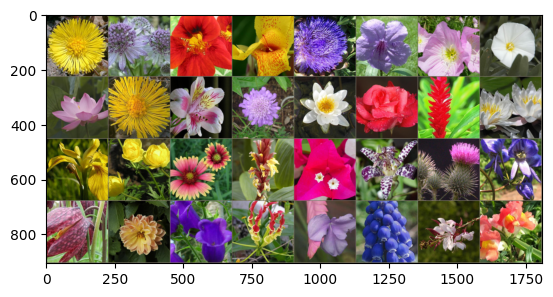

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to show images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)


Load and modify VGG19

In [6]:
import torch
import torchvision.models as models
from torch import nn

# Load the pre-trained VGG19 model
vgg19 = models.vgg19(pretrained=True)

# Freeze training for all "features" layers
for param in vgg19.features.parameters():
    param.requires_grad = False

# Modify the classifier
num_features = vgg19.classifier[6].in_features
vgg19.classifier[6] = nn.Linear(num_features, 102)  # 102 is the number of flower classes

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device is: ", device)
vgg19 = vgg19.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 79.0MB/s]


Current device is:  cuda


Define Loss function and Optimizer

In [7]:
from torch import optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Only parameters of the final layers are being optimized
optimizer = optim.Adam(vgg19.classifier.parameters(), lr=0.001)


Implement the training loop

In [11]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward + optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()  # Set model to evaluate mode
        validate_model(model, criterion, val_loader)

def validate_model(model, criterion, val_loader):
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = running_corrects.double() / len(val_loader.dataset)

    print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

# Run the training and validation
train_model(vgg19, criterion, optimizer, train_loader, val_loader)


Epoch 1/5 Loss: 4.7714 Acc: 0.0343
Validation Loss: 4.0388 Acc: 0.1108
Epoch 2/5 Loss: 3.6482 Acc: 0.1843
Validation Loss: 2.8493 Acc: 0.3039
Epoch 3/5 Loss: 2.3445 Acc: 0.4235
Validation Loss: 2.1877 Acc: 0.4235
Epoch 4/5 Loss: 1.4006 Acc: 0.6353
Validation Loss: 1.9878 Acc: 0.4735
Epoch 5/5 Loss: 0.9668 Acc: 0.7578
Validation Loss: 1.8630 Acc: 0.5333
